<span style="font-family: serif;font-size: 28px;">Load and preprocess dataset</span>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

df = pd.read_csv("CDC_Diabetes_Dataset_prep.csv")
df = df.drop_duplicates().reset_index(drop=True)
df['Diabetes_012'] = df['Diabetes_012'].replace({2: 1})
print("Class distribution after combining class 1 and 2:\n", df['Diabetes_012'].value_counts())

Class distribution after combining class 1 and 2:
 Diabetes_012
0.0    188251
1.0     39657
Name: count, dtype: int64


<span style="font-family: serif;font-size: 28px;">Split dataset into train and test</span>

In [2]:
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['Diabetes_012'], random_state=42)
print("\nClass distribution in train set:\n", train_df['Diabetes_012'].value_counts())
print("Class distribution in test set:\n", test_df['Diabetes_012'].value_counts())


Class distribution in train set:
 Diabetes_012
0.0    169426
1.0     35691
Name: count, dtype: int64
Class distribution in test set:
 Diabetes_012
0.0    18825
1.0     3966
Name: count, dtype: int64


<span style="font-family: serif;font-size: 28px;">Prepare train and test data</span>

In [3]:
# train data
X_train = train_df.drop('Diabetes_012', axis=1)
y_train = train_df['Diabetes_012']

 
# test data
X_test = test_df.drop('Diabetes_012', axis=1)
y_test = test_df['Diabetes_012']


<span style="font-family: serif;font-size: 28px;">Hyperparameter tuning using Grid Search</span>

In [5]:
# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [500],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced'] 
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1
)
grid_search.fit(X_train, y_train)
print("\nBest hyperparameters found by Grid Search:\n", grid_search.best_params_)
best_params = grid_search.best_params_

 

Fitting 3 folds for each of 12 candidates, totalling 36 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'class_weight': ['balanced'], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and para


Best hyperparameters found by Grid Search:
 {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 500}


<span style="font-family: serif;font-size: 28px;">Train Random Forest model with balanced class weights</span>

In [4]:
# model = RandomForestClassifier(**best_params, random_state=42)
# model.fit(X_train, y_train)


best_params = {
    'class_weight': 'balanced',
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_split': 5,
    'n_estimators': 500
}

model = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1  # optional but recommended for speed
)

model.fit(X_train, y_train)

print("\nRandom Forest model with optimized hyperparameters trained successfully")


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y


Random Forest model with optimized hyperparameters trained successfully


In [5]:
# Make predictions on test set
 
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability for class 1


In [6]:
# Creating balanced test set 
test_class0 = test_df[test_df['Diabetes_012'] == 0]
test_class1 = test_df[test_df['Diabetes_012'] == 1]
min_class_size = min(len(test_class0), len(test_class1))

balanced_test = pd.concat([
    test_class0.sample(min_class_size, random_state=42),
    test_class1.sample(min_class_size, random_state=42)
]).sample(frac=1, random_state=42)

X_test_bal = balanced_test.drop('Diabetes_012', axis=1)
y_test_bal = balanced_test['Diabetes_012']

# Make predictions on balanced test set
y_pred_bal = model.predict(X_test_bal)
y_pred_proba_bal = model.predict_proba(X_test_bal)[:, 1]



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting functions
labels = ['No Diabetes', 'Diabetes']

def plot_confusion(y_true, y_pred, model_name):
    """Plot both regular and normalized confusion matrices"""
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Normal CM
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=True)
    plt.title(f"{model_name} - Confusion Matrix (Count)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    
    # Normalized CM
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens',
                xticklabels=labels, yticklabels=labels, cbar=True)
    plt.title(f"{model_name} - Normalized Confusion Matrix (%)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


<span style="font-family: serif;font-size: 28px;">Model Evaluation</span>

EVALUATION ON FULL TEST SET 
Accuracy: 0.7171
ROC-AUC: 0.8039

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.71      0.81     18825
         1.0       0.35      0.75      0.48      3966

    accuracy                           0.72     22791
   macro avg       0.64      0.73      0.64     22791
weighted avg       0.83      0.72      0.75     22791


Confusion Matrix:
[[13387  5438]
 [ 1010  2956]]
CONFUSION MATRIX VISUALIZATIONS - FULL TEST SET


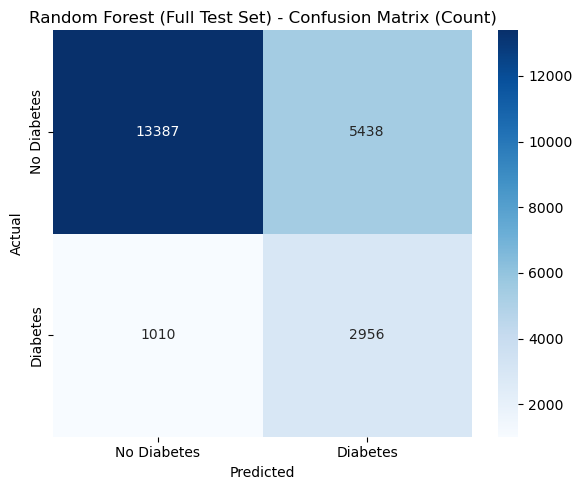

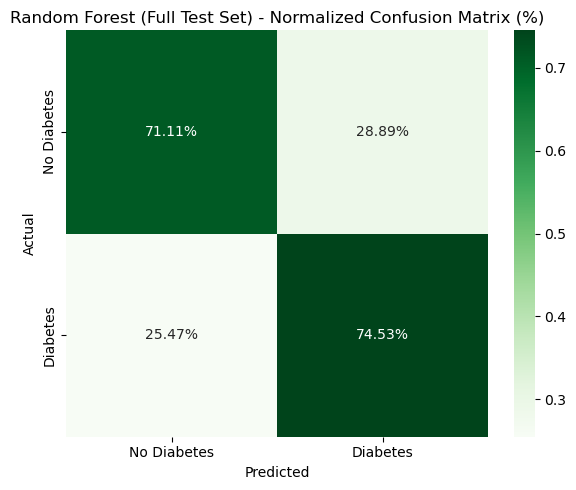

In [8]:
# Evaluate model on FULL test set 
print("EVALUATION ON FULL TEST SET ")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# Plot confusion matrices for FULL test set
print("CONFUSION MATRIX VISUALIZATIONS - FULL TEST SET")
plot_confusion(y_test, y_pred, "Random Forest (Full Test Set)")


EVALUATION ON BALANCED TEST SET (Reference only)
Accuracy: 0.7268
ROC-AUC: 0.8027

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.71      0.72      3966
         1.0       0.72      0.75      0.73      3966

    accuracy                           0.73      7932
   macro avg       0.73      0.73      0.73      7932
weighted avg       0.73      0.73      0.73      7932


Confusion Matrix:
[[2809 1157]
 [1010 2956]]
CONFUSION MATRIX VISUALIZATIONS - BALANCED TEST SET


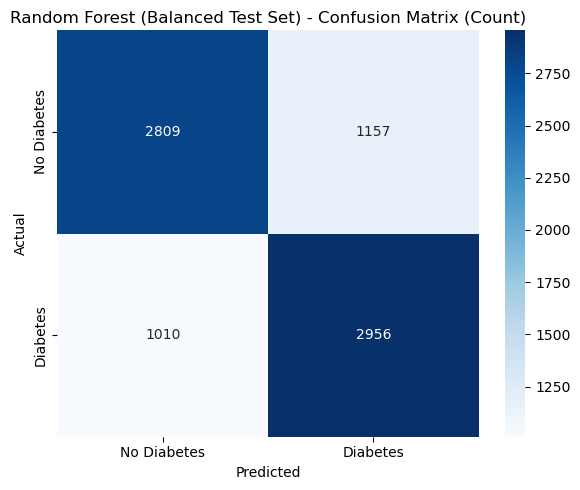

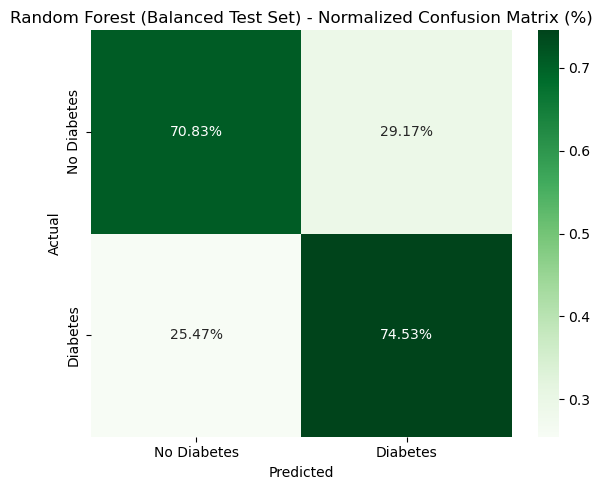

In [9]:
# Evaluate model on BALANCED test set 
print("EVALUATION ON BALANCED TEST SET (Reference only)")
print(f"Accuracy: {accuracy_score(y_test_bal, y_pred_bal):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_bal, y_pred_proba_bal):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_bal, y_pred_bal))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_bal, y_pred_bal))



# Plot confusion matrices for BALANCED test set

print("CONFUSION MATRIX VISUALIZATIONS - BALANCED TEST SET")
plot_confusion(y_test_bal, y_pred_bal, "Random Forest (Balanced Test Set)")

<span style="font-family: serif;font-size: 28px;">Feature Importance</span>

TOP 10 MOST IMPORTANT FEATURES
                 Feature  Importance
0                 HighBP    0.219486
13               GenHlth    0.215952
3                    BMI    0.138263
18                   Age    0.117043
1               HighChol    0.107220
16              DiffWalk    0.046605
6   HeartDiseaseorAttack    0.027389
20                Income    0.026647
15              PhysHlth    0.024619
2              CholCheck    0.012332


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x22503738f50>,
 [Text(0, 0, 'HighBP'),
  Text(0, 1, 'GenHlth'),
  Text(0, 2, 'BMI'),
  Text(0, 3, 'Age'),
  Text(0, 4, 'HighChol'),
  Text(0, 5, 'DiffWalk'),
  Text(0, 6, 'HeartDiseaseorAttack'),
  Text(0, 7, 'Income'),
  Text(0, 8, 'PhysHlth'),
  Text(0, 9, 'CholCheck')])

Text(0.5, 0, 'Importance')

Text(0.5, 1.0, 'Top 10 Most Important Features')

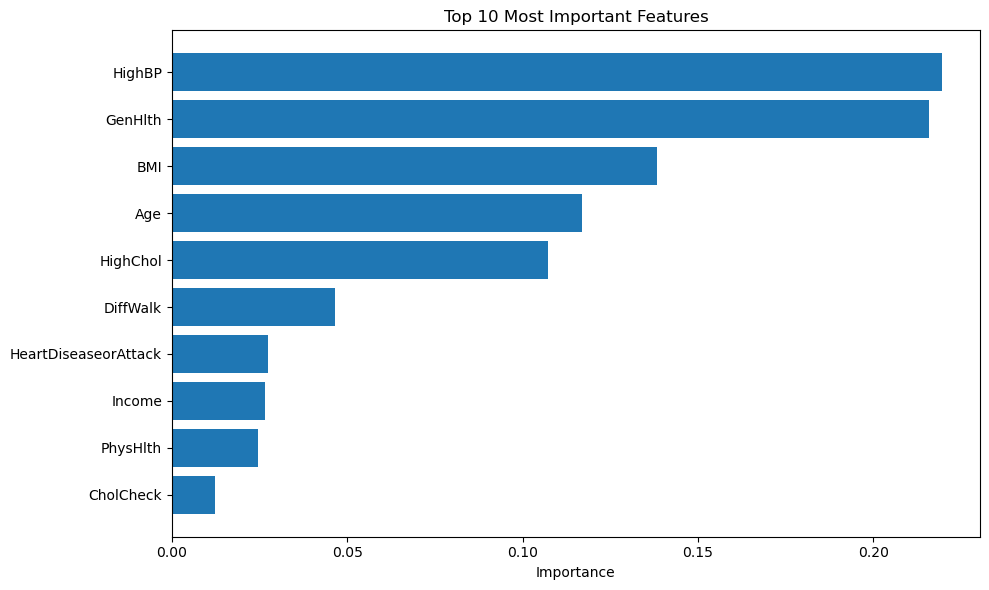

In [10]:
# Feature importance
print("TOP 10 MOST IMPORTANT FEATURES")
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'].values)
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [21]:


# SHAP Explainability Analysis (ROBUST VERSION)
import shap

print("SHAP EXPLAINABILITY ANALYSIS (ROBUST)")
# Use a sample of test data for faster computation
sample_size = 150000
X_test_sample = X_test.iloc[:sample_size].reset_index(drop=True)
y_test_sample = y_test.iloc[:sample_size].reset_index(drop=True)

print(f"Using sample of {sample_size} test samples for SHAP analysis")

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
print("Calculating SHAP values...")
shap_values_raw = explainer.shap_values(X_test_sample)

# Robust extraction of SHAP values
print("Extracting SHAP values...")
if isinstance(shap_values_raw, list):
    sv = shap_values_raw[1]
else:
    sv = shap_values_raw

# Handle different dimensionalities
if sv.ndim == 3:
    print(f"Converting 3D array {sv.shape} to 2D...")
    if sv.shape[2] == 1:
        shap_values_class1 = sv[:, :, 0]
    elif sv.shape[0] == X_test_sample.shape[0]:
        shap_values_class1 = sv[:, :, 0]
    else:
        shap_values_class1 = sv.reshape(sv.shape[0], -1)
elif sv.ndim == 2:
    shap_values_class1 = sv
else:
    shap_values_class1 = sv.reshape(sv.shape[0], -1) if sv.shape[0] == X_test_sample.shape[0] else sv

print(f"SHAP values shape: {shap_values_class1.shape}")
print(f"Test data shape: {X_test_sample.shape}")

# If shape still doesn't match, use only matching samples
if shap_values_class1.shape[0] != X_test_sample.shape[0]:
    print(f"\nShape mismatch! Using first {min(shap_values_class1.shape[0], X_test_sample.shape[0])} samples")
    min_samples = min(shap_values_class1.shape[0], X_test_sample.shape[0])
    shap_values_class1 = shap_values_class1[:min_samples]
    X_test_sample = X_test_sample.iloc[:min_samples].reset_index(drop=True)
    y_test_sample = y_test_sample.iloc[:min_samples].reset_index(drop=True)

if shap_values_class1.shape[1] != X_test_sample.shape[1]:
    print(f"\nFeature mismatch! Using first {min(shap_values_class1.shape[1], X_test_sample.shape[1])} features")
    min_features = min(shap_values_class1.shape[1], X_test_sample.shape[1])
    shap_values_class1 = shap_values_class1[:, :min_features]
    X_test_sample = X_test_sample.iloc[:, :min_features]

print(f"Final shapes - SHAP: {shap_values_class1.shape}, Data: {X_test_sample.shape}")
 

SHAP EXPLAINABILITY ANALYSIS (ROBUST)
Using sample of 150000 test samples for SHAP analysis
Calculating SHAP values...
Extracting SHAP values...
Converting 3D array (22791, 21, 2) to 2D...
SHAP values shape: (22791, 21)
Test data shape: (22791, 21)
Final shapes - SHAP: (22791, 21), Data: (22791, 21)



1. Generating SHAP Summary Plot (Bar)...


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'SHAP Feature Importance (Mean |SHAP| values)')

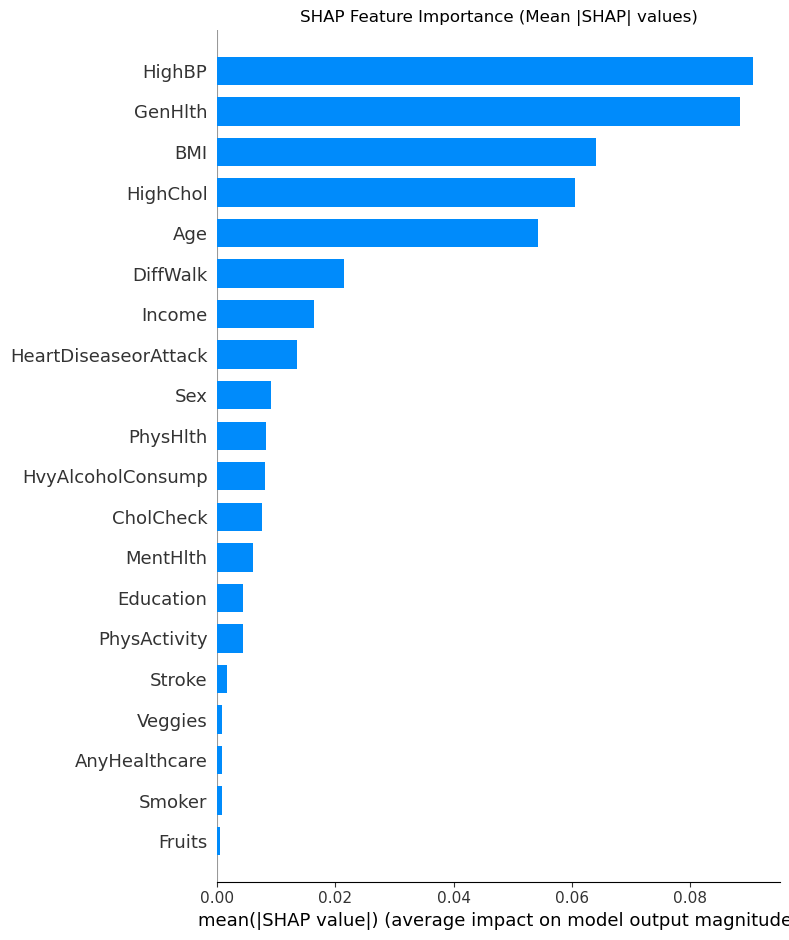

In [22]:
# 1. SHAP Summary Plot (Bar)
try:
    print("\n1. Generating SHAP Summary Plot (Bar)...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_class1, X_test_sample, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (Mean |SHAP| values)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"failed: {e}")






2. Generating SHAP Summary Plot (Beeswarm)...


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'SHAP Summary Plot - Feature Impact on Model Output')

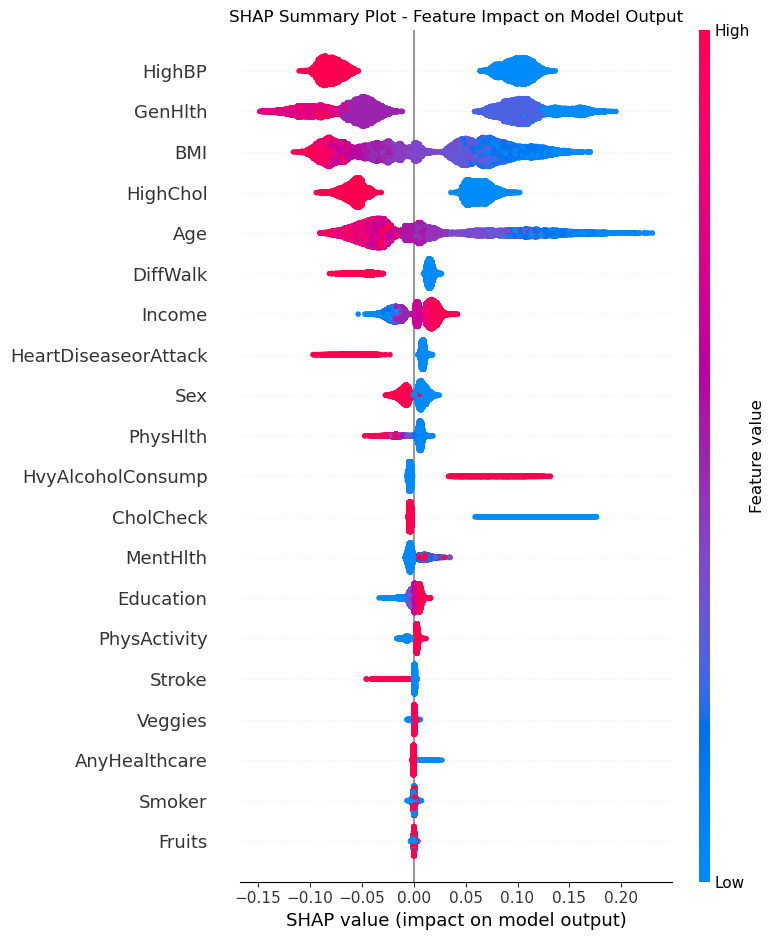

In [23]:

# 2. SHAP Summary Plot (Beeswarm)
try:
    print("\n2. Generating SHAP Summary Plot (Beeswarm)...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_class1, X_test_sample, show=False)
    plt.title("SHAP Summary Plot - Feature Impact on Model Output")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"failed: {e}")





3. Generating SHAP Dependence Plots...


<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'SHAP Dependence Plot - HighBP')

<Figure size 800x500 with 0 Axes>

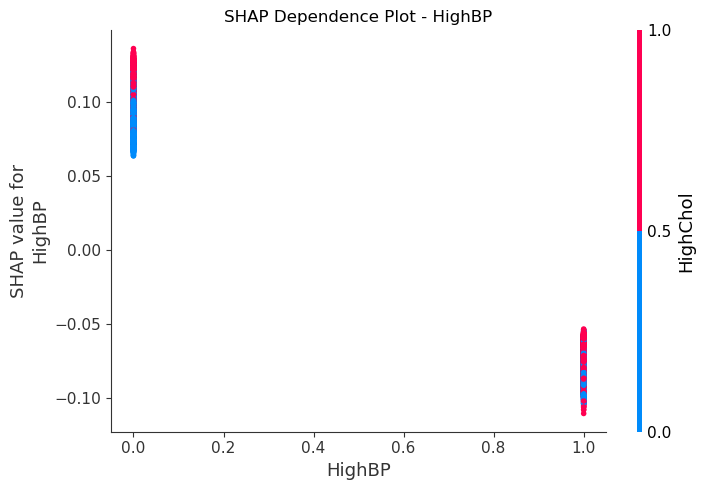

<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'SHAP Dependence Plot - GenHlth')

<Figure size 800x500 with 0 Axes>

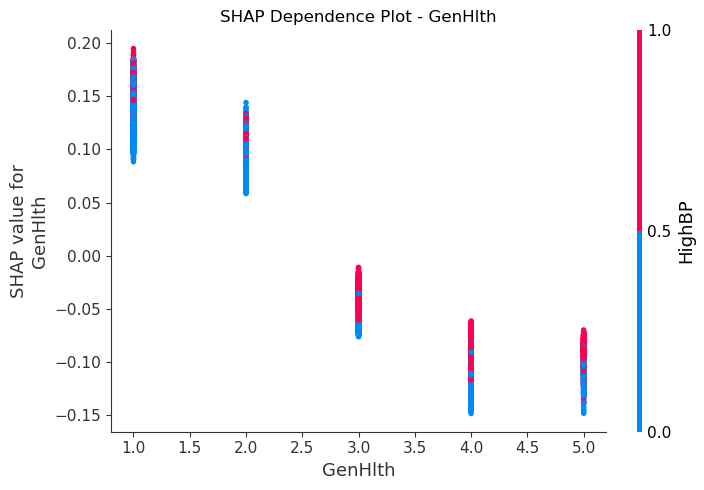

<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'SHAP Dependence Plot - BMI')

<Figure size 800x500 with 0 Axes>

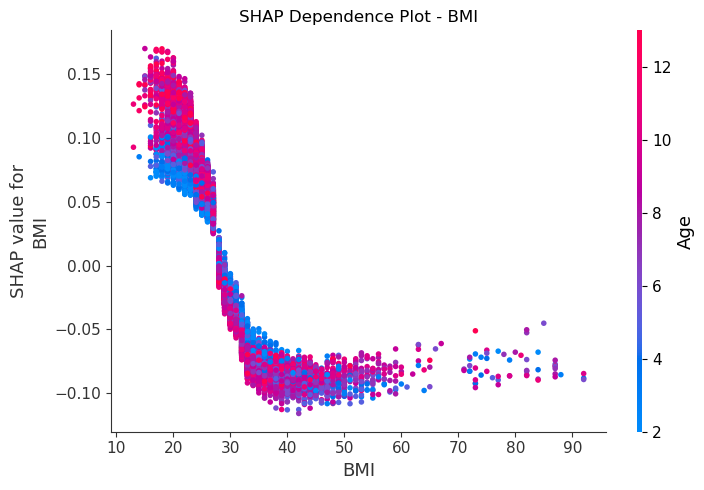

<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'SHAP Dependence Plot - HighChol')

<Figure size 800x500 with 0 Axes>

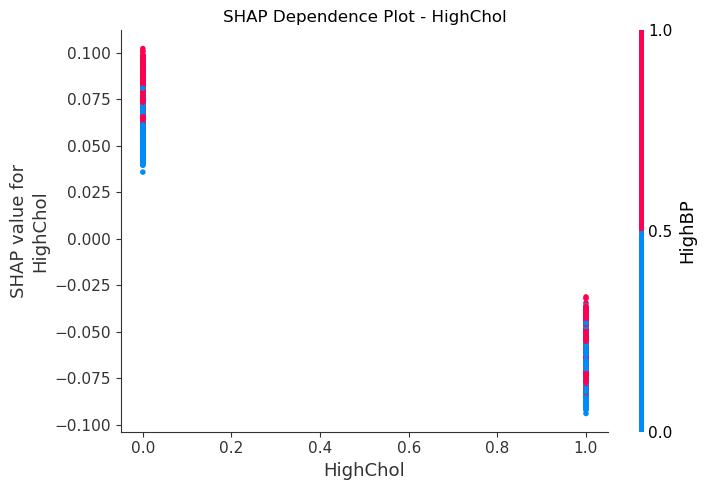

Dependence Plots completed


In [24]:
# 3. SHAP Dependence Plot (Top features)

try:
    print("\n3. Generating SHAP Dependence Plots...")
    feature_importance_temp = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'Mean_SHAP': np.abs(shap_values_class1).mean(axis=0)
    }).sort_values('Mean_SHAP', ascending=False)

    top_4_features = feature_importance_temp.head(4)['Feature'].tolist()

    for feature in top_4_features:
        try:
            plt.figure(figsize=(8, 5))
            shap.dependence_plot(feature, shap_values_class1, X_test_sample, show=False)
            plt.title(f"SHAP Dependence Plot - {feature}")
            plt.tight_layout()
            plt.show()
        except Exception as e_inner:
            print(f"{feature} failed: {e_inner}")
    print("Dependence Plots completed")
except Exception as e:
    print(f"failed: {e}")




4. Generating Feature Importance comparison...
SHAP-BASED FEATURE IMPORTANCE
                 Feature  Mean_SHAP
0                 HighBP   0.090693
13               GenHlth   0.088514
3                    BMI   0.064026
1               HighChol   0.060619
18                   Age   0.054283
16              DiffWalk   0.021405
20                Income   0.016358
6   HeartDiseaseorAttack   0.013431
17                   Sex   0.009157
15              PhysHlth   0.008278
MODEL-BASED FEATURE IMPORTANCE
                 Feature  Importance
0                 HighBP    0.219486
13               GenHlth    0.215952
3                    BMI    0.138263
18                   Age    0.117043
1               HighChol    0.107220
16              DiffWalk    0.046605
6   HeartDiseaseorAttack    0.027389
20                Income    0.026647
15              PhysHlth    0.024619
2              CholCheck    0.012332


<BarContainer object of 10 artists>

[Text(0, 0, 'HighBP'),
 Text(0, 1, 'GenHlth'),
 Text(0, 2, 'BMI'),
 Text(0, 3, 'HighChol'),
 Text(0, 4, 'Age'),
 Text(0, 5, 'DiffWalk'),
 Text(0, 6, 'Income'),
 Text(0, 7, 'HeartDiseaseorAttack'),
 Text(0, 8, 'Sex'),
 Text(0, 9, 'PhysHlth')]

Text(0.5, 0, 'Mean |SHAP|')

Text(0.5, 1.0, 'SHAP-based Feature Importance')

<BarContainer object of 10 artists>

[Text(0, 0, 'HighBP'),
 Text(0, 1, 'GenHlth'),
 Text(0, 2, 'BMI'),
 Text(0, 3, 'Age'),
 Text(0, 4, 'HighChol'),
 Text(0, 5, 'DiffWalk'),
 Text(0, 6, 'HeartDiseaseorAttack'),
 Text(0, 7, 'Income'),
 Text(0, 8, 'PhysHlth'),
 Text(0, 9, 'CholCheck')]

Text(0.5, 0, 'Importance Score')

Text(0.5, 1.0, 'Model-based Feature Importance')

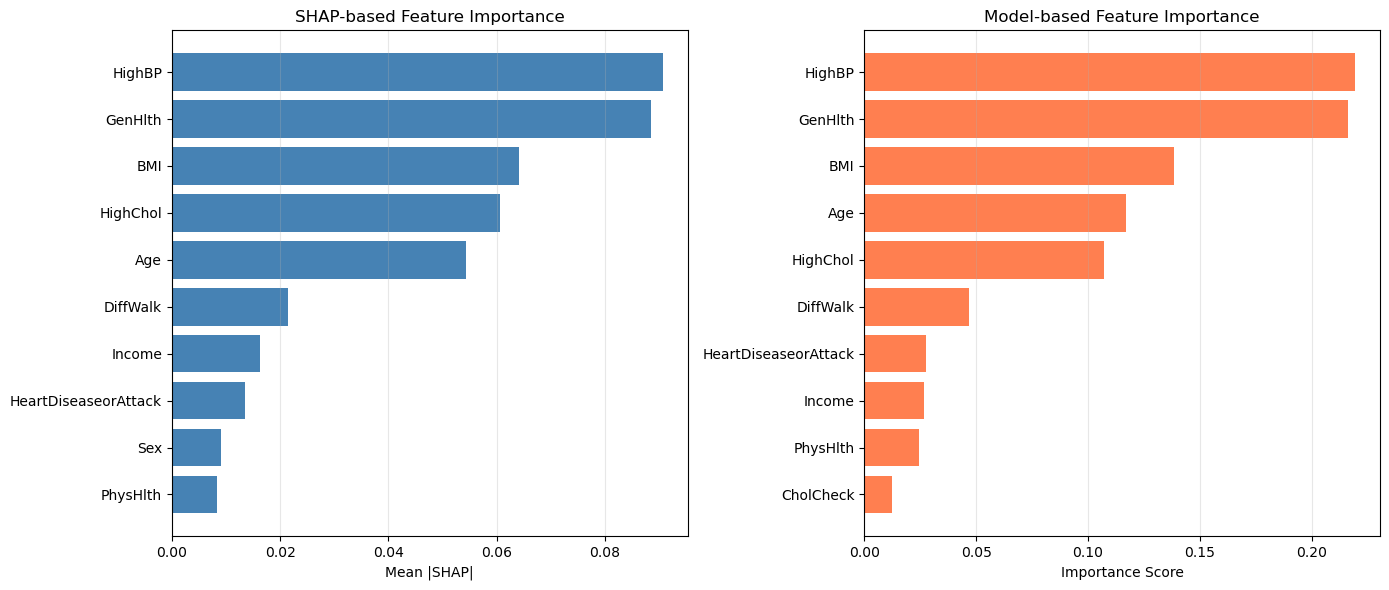

completed


In [25]:


# 4. SHAP-based Feature Importance

try:
    print("\n4. Generating Feature Importance comparison...")
    

    print("SHAP-BASED FEATURE IMPORTANCE")

    shap_feature_importance = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'Mean_SHAP': np.abs(shap_values_class1).mean(axis=0)
    }).sort_values('Mean_SHAP', ascending=False)
    
    print(shap_feature_importance.head(10))
    

    print("MODEL-BASED FEATURE IMPORTANCE")

    model_feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(model_feature_importance.head(10))
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    shap_top = shap_feature_importance.head(10)
    axes[0].barh(range(len(shap_top)), shap_top['Mean_SHAP'].values, color='steelblue')
    axes[0].set_yticks(range(len(shap_top)))
    axes[0].set_yticklabels(shap_top['Feature'].values)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Mean |SHAP|')
    axes[0].set_title('SHAP-based Feature Importance')
    axes[0].grid(axis='x', alpha=0.3)
    
    model_top = model_feature_importance.head(10)
    axes[1].barh(range(len(model_top)), model_top['Importance'].values, color='coral')
    axes[1].set_yticks(range(len(model_top)))
    axes[1].set_yticklabels(model_top['Feature'].values)
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Importance Score')
    axes[1].set_title('Model-based Feature Importance')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("completed")
except Exception as e:
    print(f"failed: {e}")


